In [1]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import os
from evaluate import compute_sim, evaluate, l2norm_numpy

def l2norm(embs):
    return {k: v/np.linalg.norm(v) for k, v in embs.items()}

# infer_dir = 'D:'
infer_dirs = ['/Users/macbook/Downloads/b5_768_sgd_lsep0.1_632', '/Users/macbook/Downloads/b5_768_adam_lsep0.1_657'][1:]
# infer_dir = 'infer/b7'
# infer_dir = 'D:'
submit_file = f'submission.csv'
if os.path.exists('D:/whale_data/train_images-384-384/train_images-384-384'):
    train_img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
else:
    train_img_dir = '/Users/macbook/works/train_images-384-384'

def get_emb(infer_dirs, subset):
    li = []
    for infer_dir in infer_dirs:
        embs = pickle_load(f"{infer_dir}/{subset}_emb.pkl")
        li.append(embs)

    if len(li) == 1:
        return li[0]

    print(f'Ensemble from {infer_dirs}')
    li0 = li[0]
    di = {}
    for k in li0.keys():
        di[k] = []
        for i in range(len(li)):
            di[k].append(li[i][k])
        di[k] = np.concatenate(di[k], 0)
    return di

train_embs = get_emb(infer_dirs, 'train')
test_embs = get_emb(infer_dirs, 'test')
val_embs = get_emb(infer_dirs, 'val')
train_df = pd.read_csv('data/train_kfold.csv')

# train_embs = l2norm(train_embs)
# test_embs = l2norm(test_embs)
# val_embs = l2norm(val_embs)

len(train_embs) + len(val_embs)

51033

In [2]:
val_df = train_df[train_df.subset == 'test'].reset_index()
val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}

In [24]:
from evaluate import compute_sim, evaluate, map_per_image
from evaluate import *

def compute_sim(train_df, train_embs, test_embs, thr=0.65, norm=False):
    # Compute center of each individual id
    label2emb = defaultdict(list)
    for label, d in train_df.groupby('individual_id'):
        for img_id in d.image.values:
            if img_id in train_embs:
                label2emb[label].append(train_embs[img_id])

    for k, v in label2emb.items():
        avg = np.mean(np.stack(v), 0)
        label2emb[k] = avg / np.linalg.norm(avg)

    train_k, train_v = dict2list(label2emb)
    test_k, test_v = dict2list(test_embs)

    if norm:
        train_v = l2norm_numpy(train_v)
        test_v = l2norm_numpy(test_v)

    cos = np.dot(test_v, train_v.T)

    records = []

    for i, scores in enumerate(tqdm(cos)):
        sort_idx = np.argsort(scores)[::-1]
        top5 = [train_k[j] for j in sort_idx[:5]]
        # top5 = [train_map[x] for x in top5]

        if thr > 0.0:
            for j in range(5):
                if scores[sort_idx[j]] < thr:
                    top5 = top5[:j] + ['new_individual'] + top5[j:4]
                    break
        
        # print(top5, scores[sort_idx][:5])
        # print(test_k[i], [f"{train_k[j]}({scores[j]:.3f})" for j in sort_idx[:5]])
        # print(scores[-1])
        records.append([test_k[i], " ".join(top5)])
    sim_df = pd.DataFrame(records, columns=['image', 'predictions'])
    return sim_df

def evaluate(val_df, train_embs, val_embs, norm=False):
    sim_df = compute_sim(val_df, train_embs, val_embs, thr=0.6, norm=norm)

    label_map = dict(zip(val_df.image, val_df.individual_id))
    
    predictions = []
    labels = []
    for i, row in sim_df.iterrows():
        label = label_map[row['image']]
        pred = row['predictions'].split(" ")
        labels.append(label)
        predictions.append(pred)

    score = map_per_set(labels, predictions)
    return score, sim_df

score, val_sim_df = evaluate(train_df, train_embs, val_embs, norm=True)
val_sim_df["gt"] = val_sim_df.image.map(val_map)
val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
val_sim_df = val_sim_df.sort_values("map")
score

100%|██████████| 10207/10207 [00:09<00:00, 1096.06it/s]


0.5545197740112995

In [12]:
from evaluate import dict2list
train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(val_embs)
class_count_df = train_df.groupby('individual_id').size().to_frame('count').reset_index()
class_count = dict(zip(class_count_df.individual_id, class_count_df['count']))
print(train_v.shape, test_v.shape)
train_v = l2norm_numpy(train_v)
test_v = l2norm_numpy(test_v)
# train_ids = np.unique([train_map[x] for x in train_k])
# allowed = []
# for i, k in enumerate(test_k):
#     if train_map[k] in train_ids:
#         allowed.append(i)
# test_k, test_v = [test_k[i] for i in allowed], [test_v[i] for i in allowed]
cosines = np.matmul(test_v, train_v.T)

(40826, 512) (10207, 512)


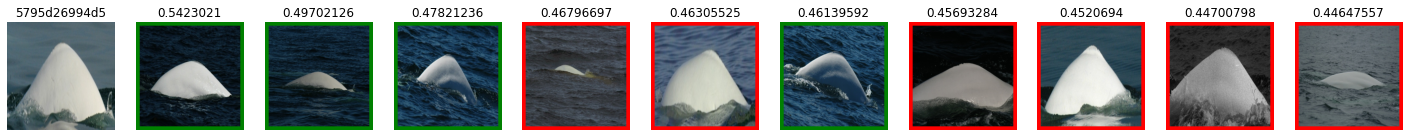

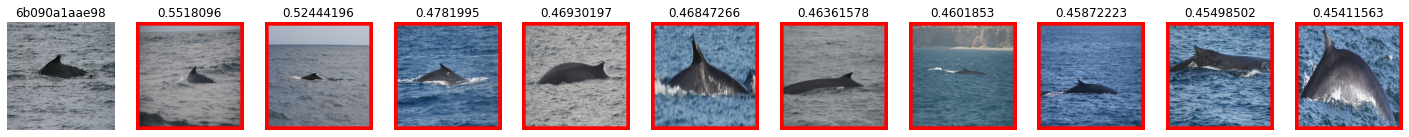

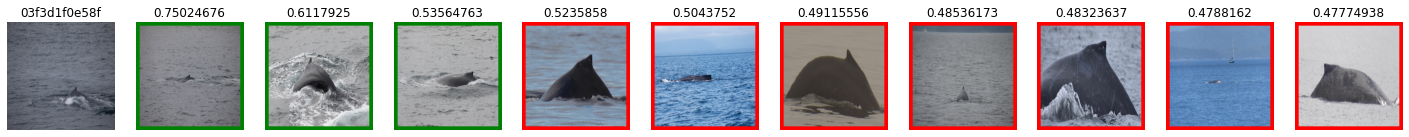

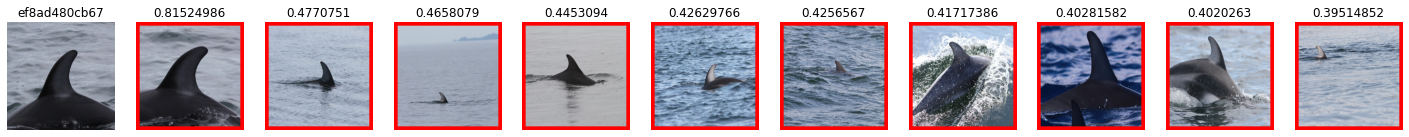

In [15]:
def add_border(img, color):
    bordersize = 14
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

c = 0
for i, scores in enumerate(cosines):
    if np.random.rand() < 0.1:
        sort_idx = np.argsort(-scores)
        topk = [train_k[j] for j in sort_idx[:10]]
        topk_score = [scores[j] for j in sort_idx[:10]]
        topk_id = [train_map[x] for x in topk]
        qid = test_k[i]
        gt = train_map[qid]
        c+=1
        imgs = [cv2.imread(f'{train_img_dir}/{qid}')[:,:,::-1]]
        for k, l in zip(topk, topk_id):
            im = cv2.imread(f'{train_img_dir}/{k}')[:,:,::-1]
            im = add_border(im, color=(255, 0, 0) if gt != l else (0, 128, 0))
            imgs.append(im)
        # Show image
        fig = plt.figure(figsize=(25, 4))
        columns = 11
        rows = 1
        for i2 in range(0, columns*rows):
            fig.add_subplot(rows, columns, i2+1)
            plt.title(f'{gt}' if i2 == 0 else topk_score[i2 - 1])
            plt.imshow(imgs[i2])
            plt.axis('off')
        
        plt.show()
        
    if c == 4:
        break
    

In [6]:
raise

RuntimeError: No active exception to reraise

In [25]:
# val_sim_df

sim_df = compute_sim(train_df, {**train_embs, **val_embs}, test_embs, thr=0.6, norm=True)
sim_df[["image", "predictions"]].to_csv('submission.csv', index=False)
sim_df.head()

100%|██████████| 27956/27956 [00:30<00:00, 931.32it/s]


,image,predictions
0,000110707af0ba.jpg,fbe2b15b5481 new_individual 74062c624dea 0ad26...
1,00150406ce5395.jpg,2280b5fcc6c2 new_individual 46d7e6928a69 299fa...
2,002e8dd5f03476.jpg,new_individual 3ab9313cbb32 8b5c8b5ec066 fba54...
3,00408e82bc01f3.jpg,6642e34b23c8 new_individual 356bfeac5626 b8cea...
4,0063923659a874.jpg,new_individual cd720f8127f5 ec900e7dd19e 253b9...


In [ ]:
# raise
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=100,metric='cosine')

train_k, train_v = dict2list({**train_embs, **val_embs})
test_k, test_v = dict2list(test_embs)
knn.fit(train_v)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [ ]:
distances, idxs = knn.kneighbors(test_v, 100, return_distance=True)

In [ ]:
from tqdm import tqdm

test_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(test_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        tar = img2id[img_id]
        test_df.append([test_k[i], tar, d]) 
    

test_df = pd.DataFrame(test_df, columns=['image', 'target', 'distances'])
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
# test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

100%|██████████| 27956/27956 [00:04<00:00, 6664.79it/s]


26     512
32     478
23     474
27     472
34     465
      ... 
97       8
96       7
98       5
99       2
100      2
Name: image, Length: 100, dtype: int64

In [ ]:
predictions = {}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

for i,row in tqdm(test_df.iterrows(), total=len(test_df)):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence > 0.6:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv(submit_file,index=False)
predictions.head()

100%|██████████| 27956/27956 [00:00<00:00, 1215364.77it/s]


,image,predictions
0,5c9e04a6e6a9a2.jpg,547afd43d437 new_individual 44ba380d5bfa 6e104...
1,7d0f46dd5f4108.jpg,982224d06f8c new_individual de44e7d9d16e 3d5a4...
2,5fb61ff7e07076.jpg,2e0b381d3467 new_individual 5525e545ae81 780fe...
3,b4950547cc22d7.jpg,abbeba14a290 new_individual 5f2296c18e26 aa169...
4,d846a86edded63.jpg,03a3bbaeed84 new_individual 2ac23ad5a020 3b4cd...


In [ ]:
# sim_df = sim_df.sort_values('image')
# sim_df.to_csv('submission.csv', index=False)

# s655_df = pd.read_csv('submission_655.csv')
# s655_df= s655_df.sort_values('image')
# s655_df.to_csv('submission_655.csv', index=False)